<center><span style="font-size: 40px; color: #ff80aa; font-weight: bold;">Top 100 Kdrama 2023</span></center>

<center><span style="font-size: 40px; color: black; font-weight: bold;">Exploratory Data Analysis</span></center>


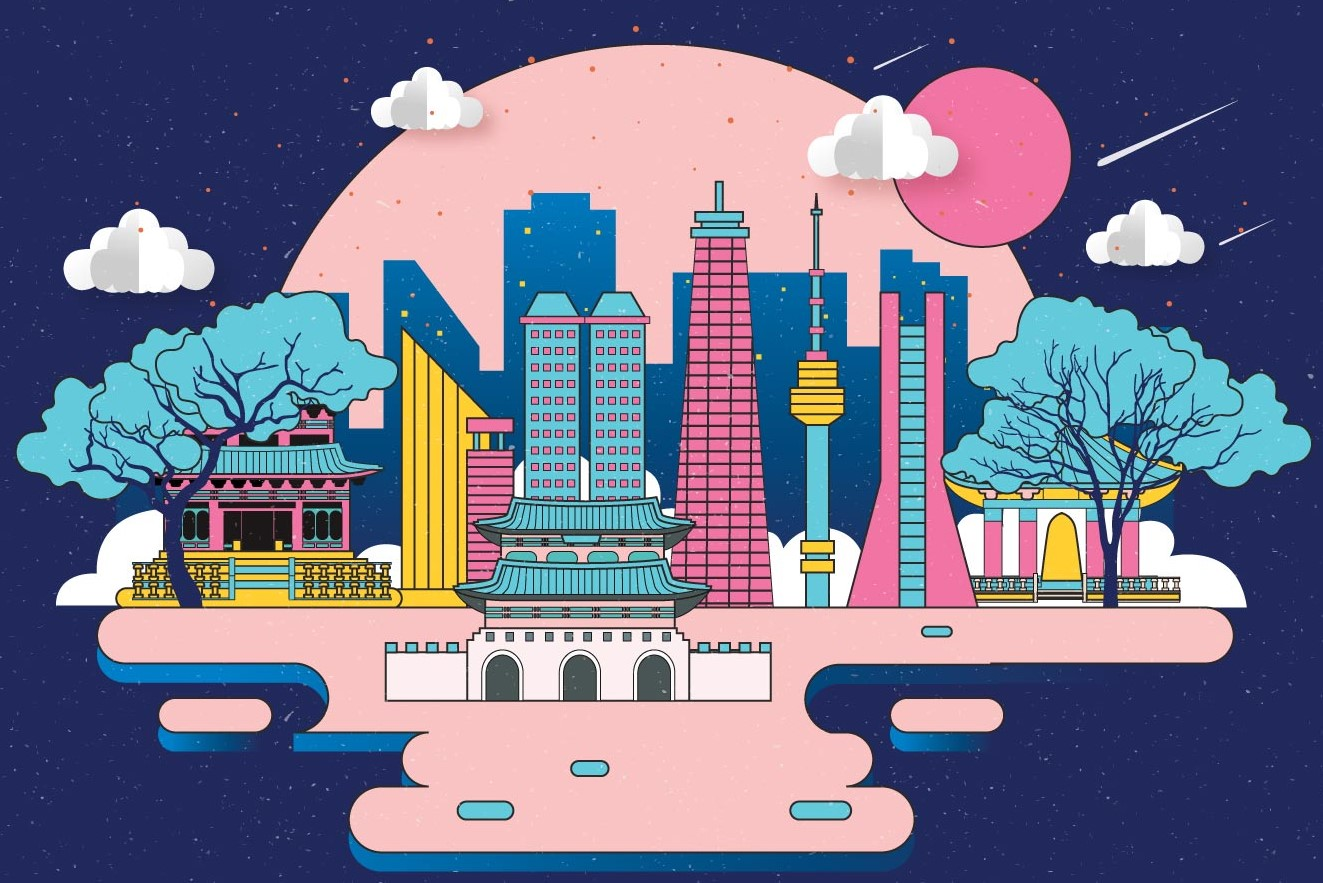

* What are the **most popular genres** in 2023?
* Who are the **most casted actors** in the top 100 kdramas?
* What are the **most popular days** for airing K-Dramas?
* Is there a **correlation** between the ranking and number of episodes of the K-Drama?

    <span style="font-size: 20px; color: #ff80aa; font-weight: bold;">Let's find out! </span> 🧐

<h1 id="loading">
<span style= "color: #ff80aa; font-weight: bold;">Data loading</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-100-k-drama-2023/top100_kdrama.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns                       
import matplotlib.pyplot as plt             
%matplotlib inline     
sns.set(color_codes=True)

In [3]:
kdrama = pd.read_csv('../input/top-100-k-drama-2023/top100_kdrama.csv')
kdrama.head()

,ID,Title,Genre,Tags,Synopsis,Rank,Popularity,Score,Episodes,Duration,Watchers,Start_date,End_date,Day_aired,Main Role
0,1,Move to Heaven,"Life, Drama","Uncle-Nephew Relationship, Autism, Death, Sava...",Han Geu Roo is a 20-year-old with Autism. He w...,8,94,9.2,10,52,"64,103",5/14/2021,NaN,Friday,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee"
1,2,Weak Hero Class 1,"Action, Youth, Drama","Smart Male Lead, Bromance, School Bullying, Vi...",Yeon Shi Eun is a model student who ranks at t...,12,290,9.1,8,40,"32,415",11/18/2022,NaN,Friday,"Park Ji Hoon, Hong Kyung, Choi Hyun Wook, Kim ..."
2,3,Hospital Playlist Season 2,"Romance, Life, Drama, Medical","Multiple Mains, Band, Music, Strong Female Lea...",Everyday is extraordinary for five doctors and...,14,177,9.1,12,100,"43,574",6/17/2021,9/16/2021,Thursday,"Jo Jung Suk, Jung Kyung Ho, Jeon Mi Do, Yoo Ye..."
3,4,Flower of Evil,"Thriller, Romance, Crime, Melodrama","Deception, Family Secret, Mystery, Suspense, S...",Although Baek Hee Sung is hiding a dark secret...,16,31,9.1,16,70,"94,811",7/29/2020,9/23/2020,"Wednesday, Thursday","Lee Joon Gi, Jang Hee Jin, Moon Chae Won, Seo ..."
4,5,Hospital Playlist,"Romance, Life, Drama, Medical","Nice Male Lead, Multiple Mains, Slow Romance, ...",The stories of people going through their days...,17,51,9.1,12,90,"81,568",3/12/2020,5/28/2020,Thursday,"Jo Jung Suk, Jung Kyung Ho, Jeon Mi Do, Yoo Ye..."


In [4]:
kdrama.isna().sum()

ID             0
Title          0
Genre          0
Tags           0
Synopsis       0
Rank           0
Popularity     0
Score          0
Episodes       0
Duration       0
Watchers       0
Start_date     0
End_date      12
Day_aired      0
Main Role      0
dtype: int64

We have some missing values for the end date of kdramas. 
But we know the date each kdrama started airing, the number of episodes and also the day(s) of the week when it aired so what about let's calculate the **end date**?🤓

In [5]:
kdrama_copy = kdrama.copy()

<h1 id="null">
<span style= "color: #ff80aa; font-weight: bold;">Null values imputation</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [6]:
def impute_end_date(kdrama_copy, start_date_col='Start_date', day_aired_col='Day_aired', episodes_col='Episodes'):
    """
    Imputes missing End_date values in a kdrama DataFrame based on the provided Start_date, Day_aired, and Episodes information.
    """
    # Convert Start_date to a datetime object and format it
    kdrama_copy[start_date_col] = pd.to_datetime(kdrama_copy[start_date_col]).dt.strftime('%d/%m/%Y')

    # Split the Day_aired string into individual days
    kdrama_copy[day_aired_col] = kdrama_copy[day_aired_col].str.split(', ')

    # Iterate over the rows of the DataFrame and impute missing End_date values
    for i, row in kdrama_copy[kdrama_copy['End_date'].isnull()].iterrows():
        days_aired = row[day_aired_col]

        # Check if the show airs once or twice a week
        if len(days_aired) == 1:
            # Impute missing end_date values based on the assumption that the show airs once a week on the same day
            kdrama_copy.at[i, 'End_date'] = (pd.to_datetime(row[start_date_col], format='%d/%m/%Y')
                                         + pd.DateOffset(days=7*(row[episodes_col]-1))).normalize().strftime('%d/%m/%Y')

        elif len(days_aired) == 2:
            # Impute missing end_date values based on the assumption that the show airs twice a week on the same days
            kdrama_copy.at[i, 'End_date'] = (pd.to_datetime(row[start_date_col], format='%d/%m/%Y')
                                         + pd.DateOffset(days=6*(row[episodes_col]-2))).strftime('%d/%m/%Y')

        else:
            # Handle the case where there are more than 2 days of airing per week
            print(f"Error: Can't handle more than 2 days of airing per week for kdrama {row['Title']}")

    # Format the End_date column
    kdrama_copy['End_date'] = pd.to_datetime(kdrama_copy['End_date']).dt.strftime('%d/%m/%Y')

    return kdrama_copy


In [7]:
imputed_kdrama = impute_end_date(kdrama_copy)

In [8]:
imputed_kdrama.head()

,ID,Title,Genre,Tags,Synopsis,Rank,Popularity,Score,Episodes,Duration,Watchers,Start_date,End_date,Day_aired,Main Role
0,1,Move to Heaven,"Life, Drama","Uncle-Nephew Relationship, Autism, Death, Sava...",Han Geu Roo is a 20-year-old with Autism. He w...,8,94,9.2,10,52,"64,103",14/05/2021,16/07/2021,[Friday],"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee"
1,2,Weak Hero Class 1,"Action, Youth, Drama","Smart Male Lead, Bromance, School Bullying, Vi...",Yeon Shi Eun is a model student who ranks at t...,12,290,9.1,8,40,"32,415",18/11/2022,01/06/2023,[Friday],"Park Ji Hoon, Hong Kyung, Choi Hyun Wook, Kim ..."
2,3,Hospital Playlist Season 2,"Romance, Life, Drama, Medical","Multiple Mains, Band, Music, Strong Female Lea...",Everyday is extraordinary for five doctors and...,14,177,9.1,12,100,"43,574",17/06/2021,16/09/2021,[Thursday],"Jo Jung Suk, Jung Kyung Ho, Jeon Mi Do, Yoo Ye..."
3,4,Flower of Evil,"Thriller, Romance, Crime, Melodrama","Deception, Family Secret, Mystery, Suspense, S...",Although Baek Hee Sung is hiding a dark secret...,16,31,9.1,16,70,"94,811",29/07/2020,23/09/2020,"[Wednesday, Thursday]","Lee Joon Gi, Jang Hee Jin, Moon Chae Won, Seo ..."
4,5,Hospital Playlist,"Romance, Life, Drama, Medical","Nice Male Lead, Multiple Mains, Slow Romance, ...",The stories of people going through their days...,17,51,9.1,12,90,"81,568",12/03/2020,28/05/2020,[Thursday],"Jo Jung Suk, Jung Kyung Ho, Jeon Mi Do, Yoo Ye..."


In [9]:
imputed_kdrama.describe()

,ID,Rank,Popularity,Score,Episodes,Duration
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,50.500000,179.480000,319.730000,8.770000,18.08000,66.540000
std,29.011492,106.655916,367.437313,0.159228,12.24636,13.105955
min,1.000000,8.000000,1.000000,8.600000,6.00000,30.000000
25%,25.750000,90.750000,88.750000,8.600000,12.00000,60.000000
50%,50.500000,179.000000,194.500000,8.700000,16.00000,67.000000
75%,75.250000,262.250000,397.500000,8.900000,20.00000,75.000000
max,100.000000,368.000000,2197.000000,9.200000,100.00000,100.000000


<h1 id="outlier">
<span style= "color: #ff80aa; font-weight: bold;">Detecting outliers</span>
<a class="anchor-link" href="">¶</a>
</h1>

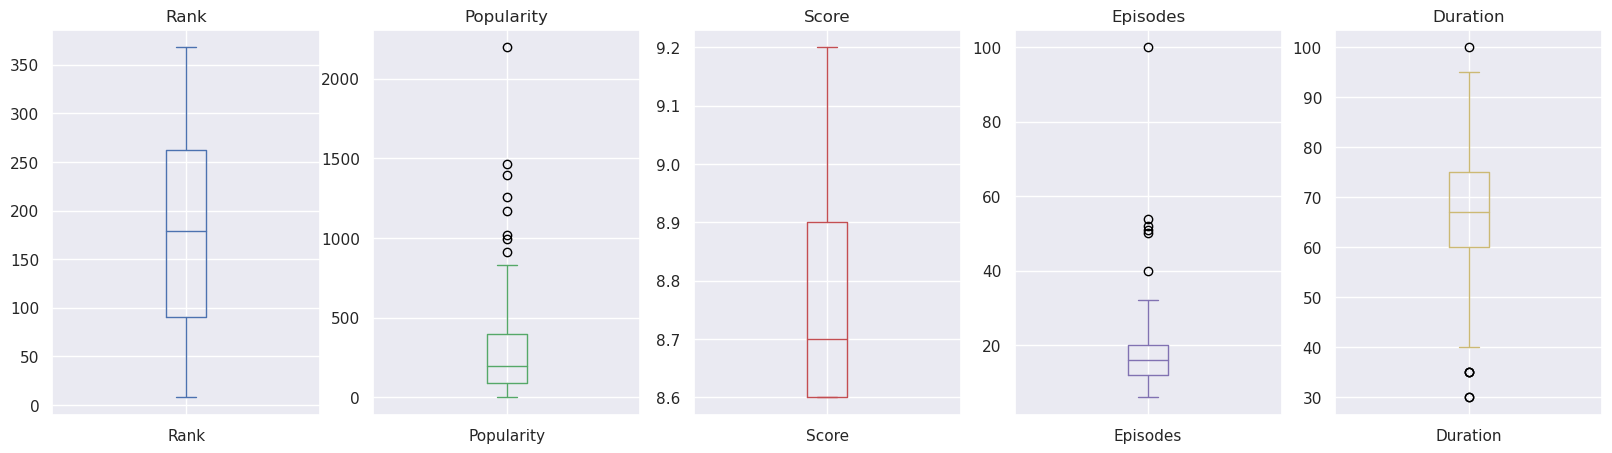

In [10]:
# Define colors for each boxplot
boxplot_colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974']

# Select columns for boxplots
boxplot_cols = ['Rank', 'Popularity', 'Score', 'Episodes', 'Duration']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(boxplot_cols), figsize=(20,5))

# Create boxplots for each selected column
for i, col in enumerate(boxplot_cols):
    imputed_kdrama.boxplot(column=col, ax=axes[i], color=boxplot_colors[i])
    axes[i].set_title(col)

# Show plot
plt.show()


* The newer K-Dramas stand worse on the leaderboard, having higher Popularity Ranks
* The older K-Dramas have more episodes (Empress Ki, Jewel in the Palace)

<h1 id="genres">
<span style= "color: #ff80aa; font-weight: bold;">1. What are the most popular genres in 2023?</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [11]:
# Counting individual genre
from collections import Counter

genres_list = []
for genres in imputed_kdrama['Genre'].to_list():
    genres = genres.strip().split(", ")
    for genres in genres:
        genres_list.append(genres)
        
genres_df = pd.DataFrame.from_dict(Counter(genres_list),orient='index').rename(columns={0:'Count'})
genres_df.sort_values(by='Count',ascending = False,inplace = True)
genres_df.head()


,Count
Drama,63
Romance,45
Thriller,33
Mystery,31
Comedy,28


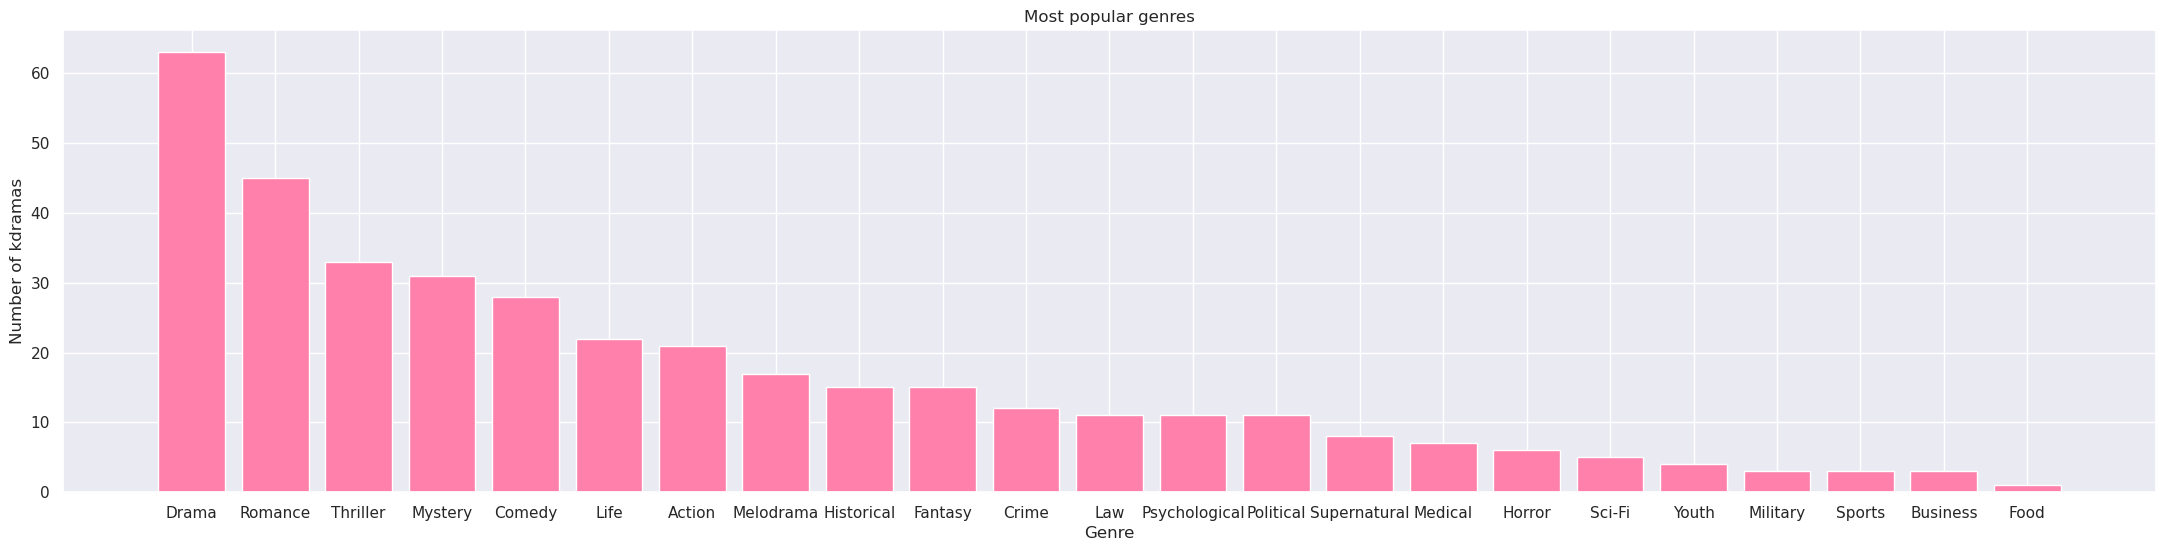

In [12]:
plt.figure(figsize=(27, 6))
plt.bar(genres_df['Count'].index,genres_df['Count'], color='#ff80aa')
#plt.xticks(rotation=90)
plt.title('Most popular genres')
plt.xlabel('Genre')
plt.ylabel('Number of kdramas')
plt.show()
plt.show()

**Top 5 genres** for the best 100 K-Dramas are:
* Drama
* Romance
* Thriller
* Mystery
* Comedy


<h1 id="actors">
<span style= "color: #ff80aa; font-weight: bold;">2. Who are the most casted actors in top 100 Kdramas?</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [13]:
# Counting individual actor
from collections import Counter

actors_list = []
for actors in imputed_kdrama['Main Role'].to_list():
    actors = actors.strip().split(", ")
    for actor in actors:
        actors_list.append(actor)
        
actors_df = pd.DataFrame.from_dict(Counter(actors_list), orient='index').rename(columns={0:'Count'})
actors_df.sort_values(by='Count', ascending=False, inplace=True)

# Filter actors that appear more than twice
actors_df = actors_df[actors_df['Count'] > 2]
actors_df.head()

,Count
Lee Do Hyun,5
Jung Kyung Ho,5
Lee Jung Eun,5
Song Joong Ki,5
Yoo Yeon Seok,4


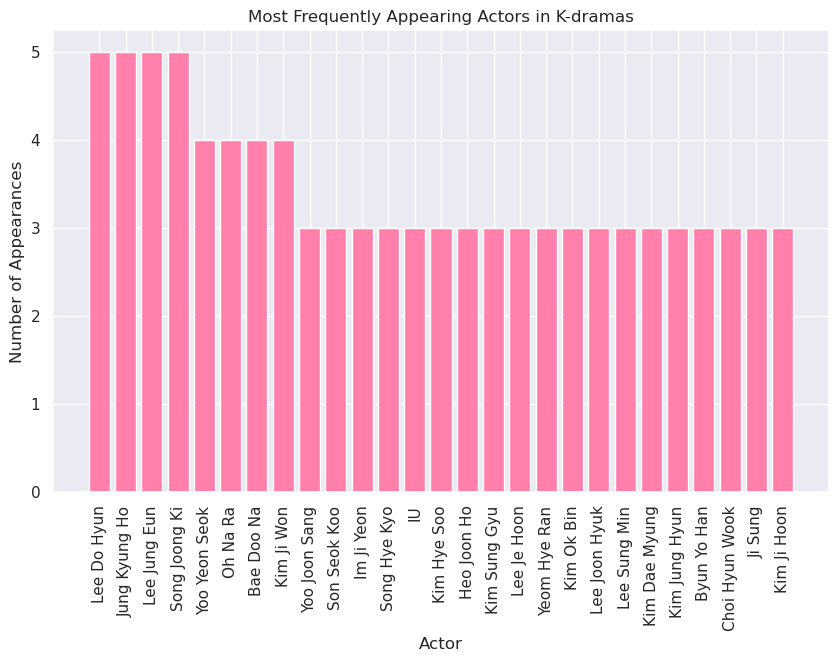

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(actors_df[actors_df['Count']>2].index, actors_df[actors_df['Count']>2]['Count'], color='#ff80aa')
plt.xticks(rotation=90)
plt.title('Most Frequently Appearing Actors in K-dramas')
plt.xlabel('Actor')
plt.ylabel('Number of Appearances')
plt.show()


**Top 5 actors** for the best 100 K-Dramas are:
* Lee Do Hyun
* Jung Kyung Ho
* Lee Jung Eun
* Song Joong Ki
* Yoo Yeon Seok


<h1 id="days">
<span style= "color: #ff80aa; font-weight: bold;">3. What are the most popular days for airing K-Dramas?</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [15]:
days_df = pd.DataFrame(imputed_kdrama['Day_aired'].explode().value_counts())
days_df.index.name = 'Day'
days_df.reset_index(inplace=True)
days_df.columns = ['Day', 'Count']
days_df

,Day,Count
0,Saturday,48
1,Friday,34
2,Sunday,28
3,Monday,21
4,Tuesday,21
5,Thursday,18
6,Wednesday,16


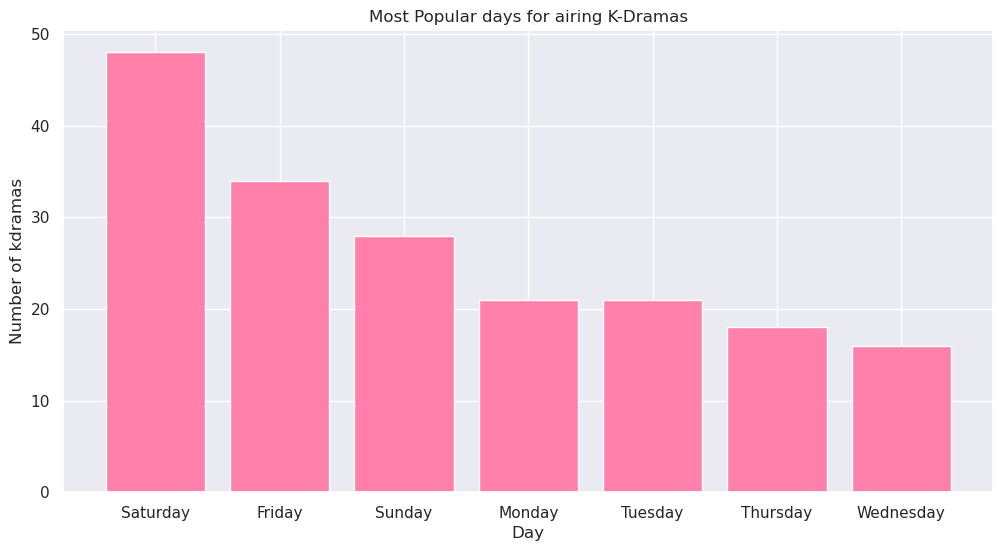

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(days_df['Day'], days_df['Count'], color='#ff80aa')
plt.title('Most Popular days for airing K-Dramas')
plt.xlabel('Day')
plt.ylabel('Number of kdramas')
plt.show()


Most Kdramas are aired on **Saturday and Friday**. It makes sense because most people have more free time on weekends.

<h1 id="corr">
<span style= "color: #ff80aa; font-weight: bold;">4. Is there a correlation between the ranking and number of episodes of the K-Drama?</span>
<a class="anchor-link" href="">¶</a>
</h1>

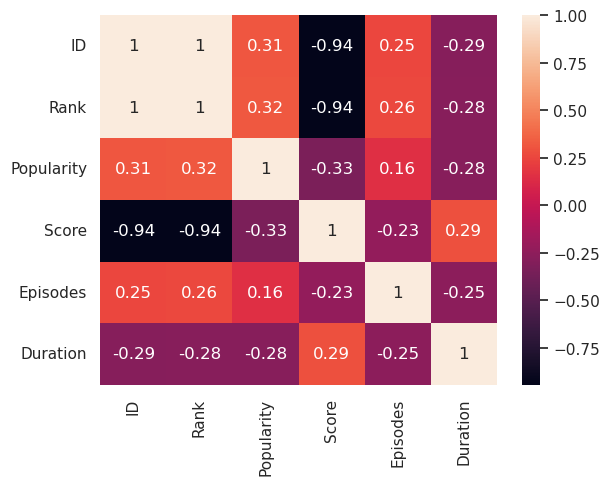

In [17]:
# create the correlation matrix

corr_matrix = imputed_kdrama.corr()

# create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='rocket')

# show the plot
plt.show()

* There is a **positive correlation** between Rank and Popularity (0.32. 
* We can  observe a **very high negative correlation** between Rank and Score (-0.94), meaning that a higher score is linked to a smaller(better) rank. 
* Also, Kdramas with **many episodes** may stand **worse on the leaderboard** than those with fewer episodes. This could explain why there is a trend lately for K-Drama series to have 8-12 episodes. (correlations of 0.26, 0.16)

<AxesSubplot:xlabel='Episodes', ylabel='Rank'>

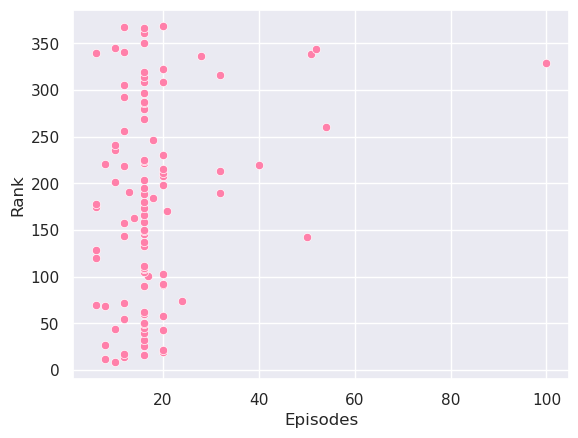

In [18]:
sns.scatterplot(data=imputed_kdrama, x="Episodes", y="Rank", color='#ff80aa')

There is **no clear relationship** between Number of episodes and the Rank of K-Dramas. This was predictable because of the low value of the correlation coefficient we identifiend above.

<h1 id="conclusion">
<span style= "color: #ff80aa; font-weight: bold;">Conclusions</span>
<a class="anchor-link" href="">¶</a>
</h1>

There is a trend for K-Dramas to:
* Have one or more of the genres: Drama, Romance, Thriller, Mystery, Comedy
* Air on weekends
* Have less episodes



<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#ff80aa;
           font-family:Verdana;
           letter-spacing:0.5px">

<center><span style="font-size: 30px; color: white; font-weight: bold;">Thank you for checking out my notebook! 😊✨</span></center>
</div>  